In [9]:
import sncosmo
import sfdmap
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import astropy
from astropy.table import Table
from astropy import constants
import requests
import seaborn as sns
import json
from pydantic import BaseModel
from typing import Literal, List, Dict
import math

import time
import selenium
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from sncosmo.fitting import DataQualityError


snadoid_to_tbound = {
    228 : [58300, 58350],
    116 : [58330, 58360],
    135 : [58300, 58350],
    157 : [58290, 58340],
    229 : [58230, 58280],
    211 : [58625, 58675],
    238 : [58300, 58350],
}

class Observation(BaseModel):
    mjd: float
    flux: float
    fluxerr: float
    zp: float = 8.9
    zpsys: Literal['ab', 'vega'] = 'ab'
    band: str
    
class Target(BaseModel):
    light_curve: List[Observation]
    ebv: float
    t_min: float
    t_max: float
    count: int
    name_model: str 
    redshift: List[float]
    
class Point(BaseModel):
    time: float
    flux: float
    band: str

class Result(BaseModel):
    flux_jansky: List[Point]
    degrees_of_freedom: int
    covariance: List[List[float]]
    chi2: float
    parameters: Dict[str, float]
    
    
def fit(data, name_model, ebv, redshift, snadid):
    dust = sncosmo.CCM89Dust()
    model = sncosmo.Model(source=name_model, effects=[dust], effect_names=['mw'], effect_frames=['obs'])
    model.set(mwebv=ebv)
    snadid = int(snadid[4:])
    try: 
        if snadid in snadoid_to_tbound.keys():
            print(snadid)
            summary, fitted_model = sncosmo.fit_lc(data, model, ['z', 't0', 'amplitude'], #guess_z=True,
                                                   bounds={'z':(redshift[0], redshift[1]), 
                                                           't0':(snadoid_to_tbound[snadid][0], snadoid_to_tbound[snadid][1])})
                                    
        else:
            summary, fitted_model = sncosmo.fit_lc(data, model, ['z', 't0', 'amplitude'], #guess_z=True, 
                                                   bounds={'z':(redshift[0], redshift[1])}
                                                  )
        print(fitted_model.parameters)
        
    except DataQualityError as d: 
        print('DataQualityError')
        df = pd.DataFrame({'name' : snadid, 'model' : name_model, 'error' : 'DataQualityError', 'text' : str(d)})
        df.to_csv('id_exception_v22.csv', mode='a', index= False, header=False)
        return {'error' : 'DataQualityError'}
    except RuntimeError as r: 
        print('RuntimeError')
        df = pd.DataFrame([{'name' : snadid, 'model' : name_model, 'error' : 'RuntimeError', 'text' : str(r)}])
        df.to_csv('id_exception_v22.csv', mode='a', index= False, header=False)
        return {'error' : 'RuntimeError'}
    return summary, fitted_model


def get_flux_and_params(summary, data, fitted_model, t_min, t_max, count):

    segment = np.linspace(t_min, t_max, count)
    df = data.to_pandas()
    points = []
    for band in df['band'].unique():
        predicts = fitted_model.bandflux(band, segment, df['zp'][0], df['zpsys'][0])
        points += [Point(time=time, flux=flux, band=band) for time, flux in zip(segment, predicts)]
    try: cov=summary.covariance.tolist() 
    except: 
        cov=[[]] 
        print('covariance is none')
    return Result(flux_jansky=points, parameters=dict(zip(summary.param_names, summary.parameters)), 
                       degrees_of_freedom=summary.ndof, covariance=cov, chi2=summary.chisq)


def approximate(data: Target, snadid):

    df = pd.DataFrame([obs.model_dump() for obs in data.light_curve])
    table = Table.from_pandas(df)
    fit_data = fit(table, data.name_model, data.ebv, data.redshift, snadid)
    try: summary, fitted_model = fit_data
    except ValueError: return fit_data
    result = get_flux_and_params(summary, table, fitted_model, data.t_min, data.t_max, data.count)
    return result


oid_to_tmax = { # время максимума только для графика, фит строится
    169 : 58572.42763, 204 : 58605.40540, 241 : 58231.36666, 211 : 58647.32578, 238 : 58324.20177, 186 : 58198.38628,
    234 : 58224.44818, 152 : 58222.30126, 110 : 58269.19916, #228 : 58326
}


def plot(curves: Result, data, oid_namemodel, t_l, t_r):
    band_color = {'ztfr' : 'r', 'ztfg' : 'g', 'ztfi' : 'm'}
    mjd_offset = 58000
    data_r = data[data['band']=='ztfr']
    data_g = data[data['band']=='ztfg']
    if data_r.shape[0]>data_g.shape[0]:
        data_max = data_r
    else: data_max = data_g
    #key = int(oid_namemodel[4:7])
    #if key in oid_to_tmax.keys(): t_max_mag = oid_to_tmax[key] - mjd_offset
    #else: t_max_mag = data_max[data_max['mag']==data_max['mag'].min()]['mjd'].values[0] - mjd_offset
    t_l -= mjd_offset
    t_r -= mjd_offset
    data = data[((data['mjd'] - mjd_offset >= t_l) & (data['mjd'] - mjd_offset <= t_r))]
    print('Uniq band', data['band'].unique())
    curve = pd.DataFrame([obs.model_dump() for obs in curves.flux_jansky])
    fig, axs = plt.subplots(1, len(data['band'].unique()), figsize=(16,5))
    axs = np.array(axs)
    plt.suptitle(oid_namemodel, fontsize=20)
    it = 0
    for it, ax_band in enumerate(zip(axs.reshape(-1), sorted(data['band'].unique(), 
                                                             key = lambda x: 1 if x[-1]=='g' else (2 if x[-1]=='r' else 3)))):
        ax, band = ax_band[0], ax_band[1]
        data_band = data[data['band']==band]
        curve_band = curve[curve['band']==band]
        flux_max = max(data['flux'].max(), curve_band['flux'].max())
        flux_min = min(data['flux'].min(), curve_band['flux'].min())
        ax.set_xlim([t_l, t_r])
        ax.set_ylim([-5+flux_min*10**6, flux_max*10**6+10])
        ax.errorbar(data_band['mjd']-mjd_offset, data_band['flux'] * 10**6, yerr=data_band['fluxerr'] * 10**6, fmt="o", color=band_color[band], elinewidth=1, marker='.', label=band)
        ax.plot(curve_band['time']-mjd_offset, curve_band['flux'] * 10**6, color=band_color[band])
        ax.set_xlabel("MJD-58000", fontsize=16)
        ax.grid(which='major')
        matplotlib.rc('xtick', labelsize=15)
        ax.legend(prop={"size":16})
        if it==0: 
            ax.set_ylabel("Flux, " + "μ" + "Jy", fontsize=16)
            matplotlib.rc('ytick', labelsize=15)
        #plt.savefig('Lom/' + oid_namemodel)
    plt.show()
        

def task(oid, list_models, count, redshift):
    data = pd.read_csv('data_calc_ref/' + str(oid) + '.csv')
    snadid = data['Name'][0]
    oid_ebv = pd.read_csv('oid_ebv.csv')
    ebv = float(list(oid_ebv[oid_ebv['OID'] == oid]['ebv'])[0])
    data_r = data[data['band']=='ztfr']
    data_g = data[data['band']=='ztfg']
    if data_r.shape[0]>data_g.shape[0]:
        data_max = data_r
    else: data_max = data_g
    #t_max_mag = data_max[data_max['mag']==data_max['mag'].min()]['mjd'].values[0]
    #try: t_max_mag = oid_to_tmax_plot[int(snadid[4:7])] 
    #except KeyError: t_max_mag = data_max[data_max['mag']==data_max['mag'].min()]['mjd'].values[0] 
    #t_min = t_max_mag - 30
    #t_max = t_max_mag + 120
    key = int(snadid[4:7])
    if key in oid_to_tmax.keys(): t_max_mag = oid_to_tmax[key] #- mjd_offset
    else: t_max_mag = data_max[data_max['mag']==data_max['mag'].min()]['mjd'].values[0] #- mjd_offset
    max_mag = data_max['mag'][data['mjd']==t_max_mag].values[0]
    print(max_mag)
    if max_mag>=21:
        redshift = [0.035,0.65] # [-15,-22] for 21 mag
    elif max_mag>=20:
        redshift = [0.025,0.45] # [-15,-22] for 20 mag
    elif max_mag>=19:
        redshift = [0.015,0.30] # [-15,-22] for 19 mag
    #redshift = [0.01,0.65]
    print(redshift)
    t_l = t_max_mag - 30
    t_r = t_max_mag + 120
    #data = data[data['band']=='ztfr']
    data['zp'] = 8.9
    data['zpsys'] = 'ab'
    data.drop(['Unnamed: 0', 'magerr', 'clrcoeff', 'oid', 'flux', 'fluxerr', 'ref', 'referr', 'Name'], axis= 1 , inplace= True)
    data = data.rename(columns={'flux_dif': 'flux', 'flux_dif_err': 'fluxerr'})
    data.dropna()
    json_flux_dif = data.to_dict('records')
    result_list = []
    for model in list_models:
        curves = approximate(Target(light_curve=[Observation(mjd=obs['mjd'], flux=obs['flux'], fluxerr=obs['fluxerr'], 
                                                             band=obs['band'], zp=obs['zp'], zpsys=obs['zpsys']) 
                                          for obs in json_flux_dif], ebv=ebv, name_model=model, t_min=t_l, t_max=t_r, 
                                    count=count, redshift=redshift), snadid)        
        try: plot(curves, data, str(snadid)+'_'+model, t_l, t_r)
        except AttributeError:
            res = -1
        try: 
            z = curves.parameters['z']
            m_abs_max = data_r['mag'].min() - astropy.cosmology.Planck18.distmod(z).value
            res = {'name' : snadid, 'model' : model, 'M' : m_abs_max, 'chi2' : curves.chi2, 'z' : z,
                    't0' : curves.parameters['t0'], 'amplitude' : curves.parameters['amplitude'], 'mwebv' : curves.parameters['mwebv'],
                    'mwr_v' : curves.parameters['mwr_v'], 'max_mag' : max_mag}
        except AttributeError:
            res = -1
        if type(res) is dict:
            result_list.append(res)
    result_list.sort(key=lambda x: x['chi2'])
    df_result = pd.DataFrame(result_list)
    print(df_result)
    #df_result.to_csv('id_result_z_v13.csv', mode='a', index= False, header=False)
    return result_list


def get_best_fit(oid, list_models, t_min, t_max, count, redshift):
    result_list = []
    for model in list_models:
        res = task(oid, model, t_min, t_max, count, redshift)
        if type(res) is dict: result_list.append(res)
    result_list.sort(key=lambda x: x['chi2'])
    print(result_list)
    
    
#list_nugent = ['nugent-sn1a', 'nugent-sn91t', 'nugent-sn91bg', 'nugent-sn1bc', 'nugent-hyper', 'nugent-sn2n', 'nugent-sn2l', 'nugent-sn2p']
list_nugent = ['nugent-sn1a', 'nugent-sn1bc', 'nugent-sn2n', 'nugent-sn2l', 'nugent-sn2p']

       Name       R.A.      Dec.              OID  Discovery date (UT)    mag  \
7   SNAD108  257.84004  48.21127  762209400037712  2018-04-16 10:34:47  21.23   
10  SNAD111  263.42634  52.62203  796201100002136  2018-06-21 07:59:02  21.32   
11  SNAD112  263.37725  51.25848  796201400007564  2018-05-14 09:19:47  20.98   

    er_down  er_up    ref  er_ref         TNS Type      Comments  
7      0.28   0.38  20.99    0.06  AT 2018lwo  PSN  ZTF18abauopo  
10     0.28   0.39  21.72    0.15  AT 2018lwr  PSN  ZTF18abdldos  
11     0.22   0.28  22.63    0.26  AT 2018lws  PSN  ZTF18aaubejv  
19.091373
[0.015, 0.3]


/home/user/Downloads/demo/notebookenv/lib/python3.11/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


[1.29873290e-01 5.82735469e+04 1.20271324e-08 1.00000000e-02
 3.10000000e+00]
Uniq band ['ztfr' 'ztfg']


/tmp/ipykernel_15631/2336901342.py:160: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(data_band['mjd']-mjd_offset, data_band['flux'] * 10**6, yerr=data_band['fluxerr'] * 10**6, fmt="o", color=band_color[band], elinewidth=1, marker='.', label=band)


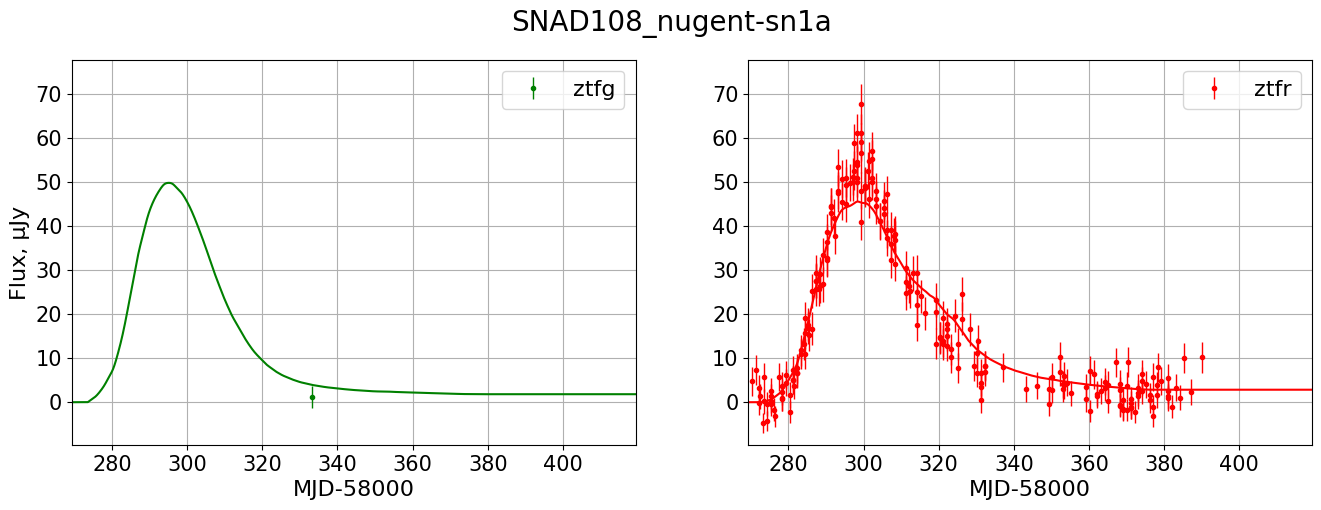

[2.43850268e-01 5.82759143e+04 1.18367911e-08 1.00000000e-02
 3.10000000e+00]
Uniq band ['ztfr' 'ztfg']


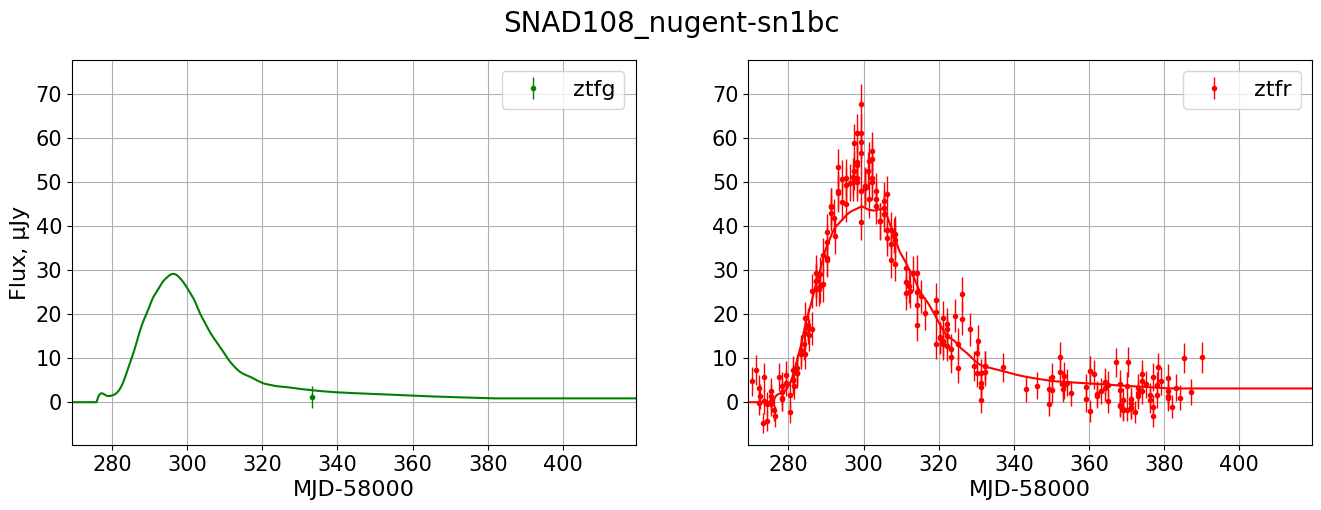

[1.50000016e-02 5.82789075e+04 1.36809451e-08 1.00000000e-02
 3.10000000e+00]
Uniq band ['ztfr' 'ztfg']


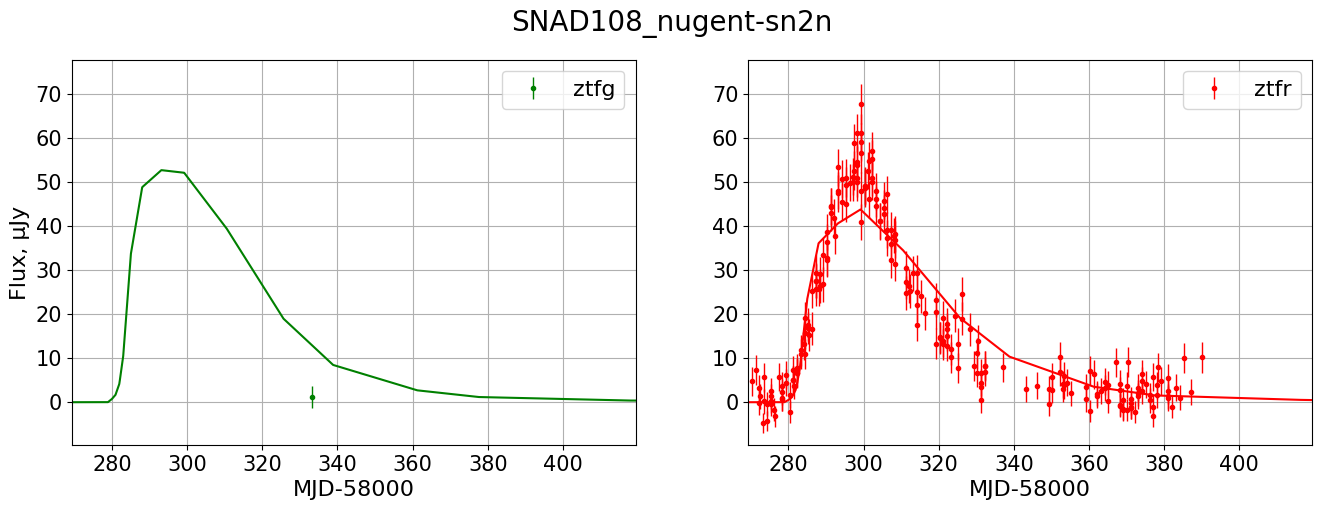

[1.48817771e-01 5.82805114e+04 1.69840659e-08 1.00000000e-02
 3.10000000e+00]
Uniq band ['ztfr' 'ztfg']


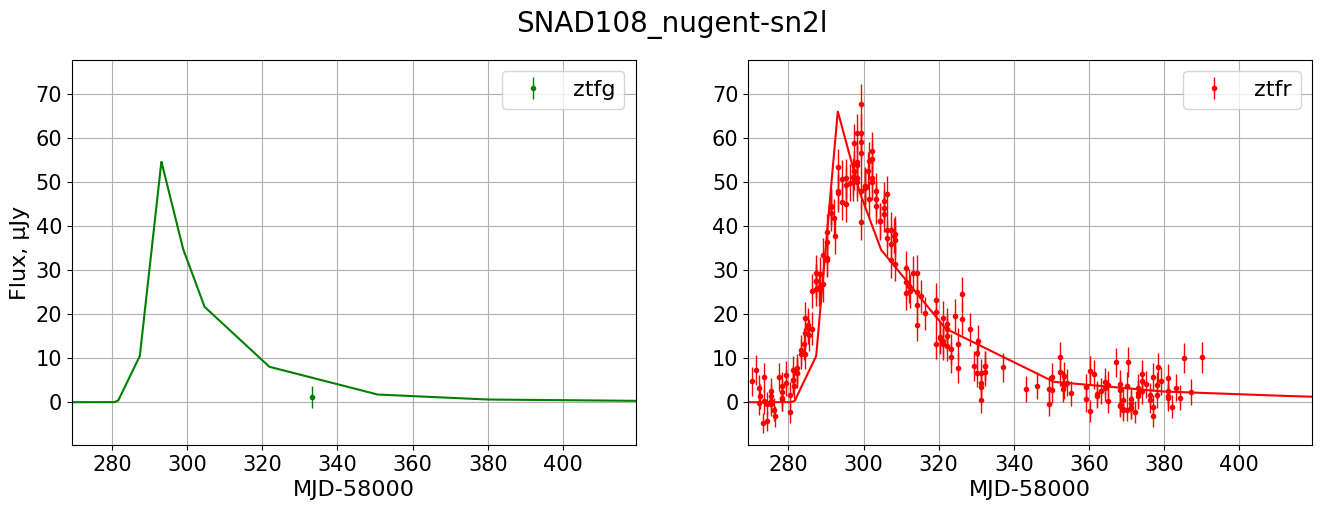

[1.15455405e-01 5.82788795e+04 9.97044697e-09 1.00000000e-02
 3.10000000e+00]
Uniq band ['ztfr' 'ztfg']


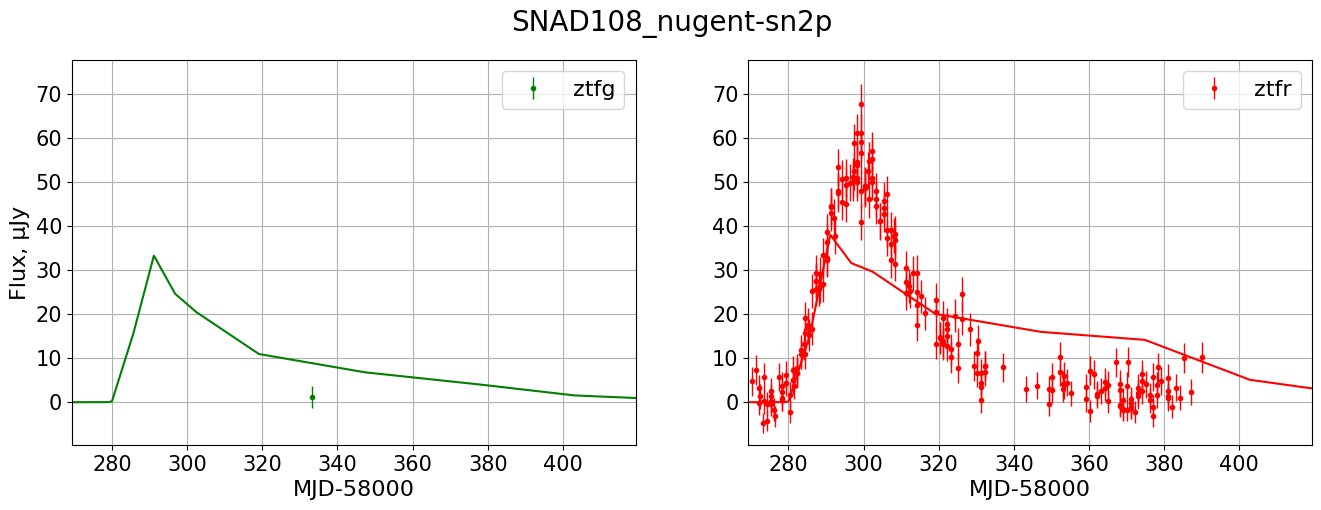

      name         model          M         chi2         z            t0  \
0  SNAD108   nugent-sn2n -15.046220  1362.548098  0.015000  58278.907457   
1  SNAD108   nugent-sn2l -20.226960  1384.121642  0.148818  58280.511440   
2  SNAD108   nugent-sn1a -19.905514  1498.595739  0.129873  58273.546886   
3  SNAD108  nugent-sn1bc -21.418872  1578.701010  0.243850  58275.914346   
4  SNAD108   nugent-sn2p -19.629907  3211.531713  0.115455  58278.879476   

      amplitude  mwebv  mwr_v    max_mag  
0  1.368095e-08   0.01    3.1  19.091373  
1  1.698407e-08   0.01    3.1  19.091373  
2  1.202713e-08   0.01    3.1  19.091373  
3  1.183679e-08   0.01    3.1  19.091373  
4  9.970447e-09   0.01    3.1  19.091373  
19.77927
[0.015, 0.3]


/home/user/Downloads/demo/notebookenv/lib/python3.11/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


[ 1.47927472e-01  5.84630228e+04 -1.73972278e-10  3.00000000e-02
  3.10000000e+00]
Uniq band ['ztfg' 'ztfr' 'ztfi']


/tmp/ipykernel_15631/2336901342.py:160: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(data_band['mjd']-mjd_offset, data_band['flux'] * 10**6, yerr=data_band['fluxerr'] * 10**6, fmt="o", color=band_color[band], elinewidth=1, marker='.', label=band)


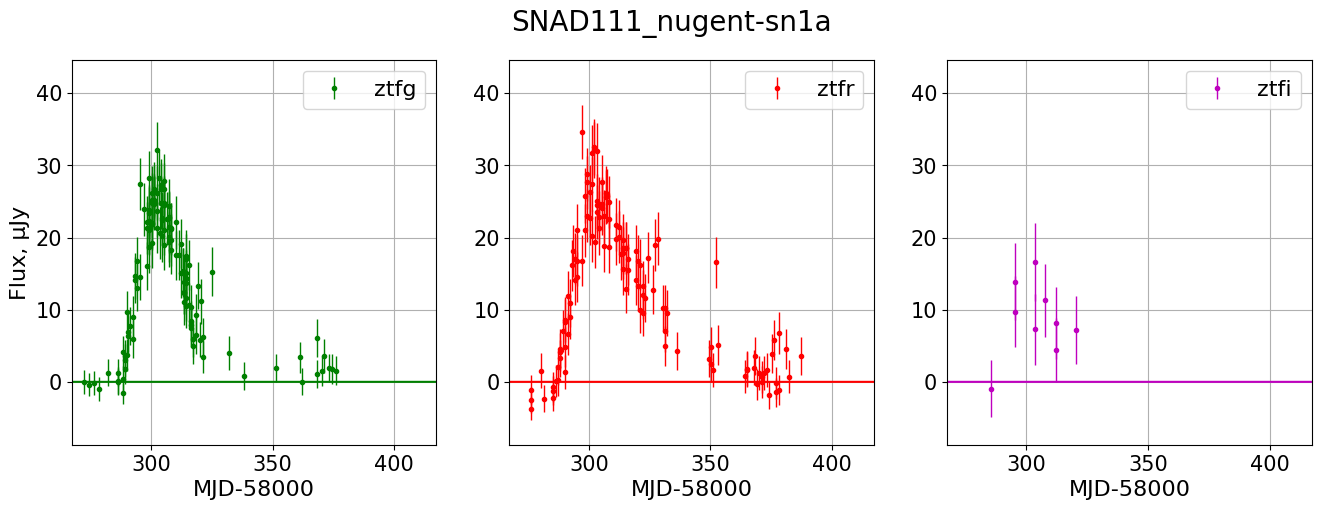

[1.58620288e-01 5.82832177e+04 7.48044168e-09 3.00000000e-02
 3.10000000e+00]
Uniq band ['ztfg' 'ztfr' 'ztfi']


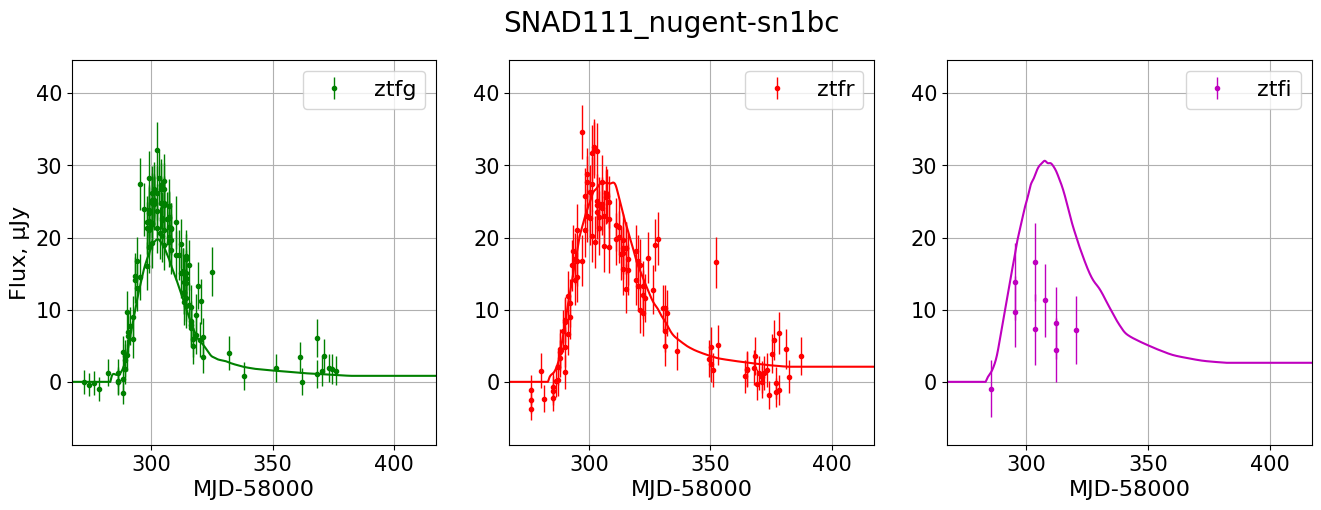

[1.50000004e-02 5.82856200e+04 6.15419149e-09 3.00000000e-02
 3.10000000e+00]
Uniq band ['ztfg' 'ztfr' 'ztfi']


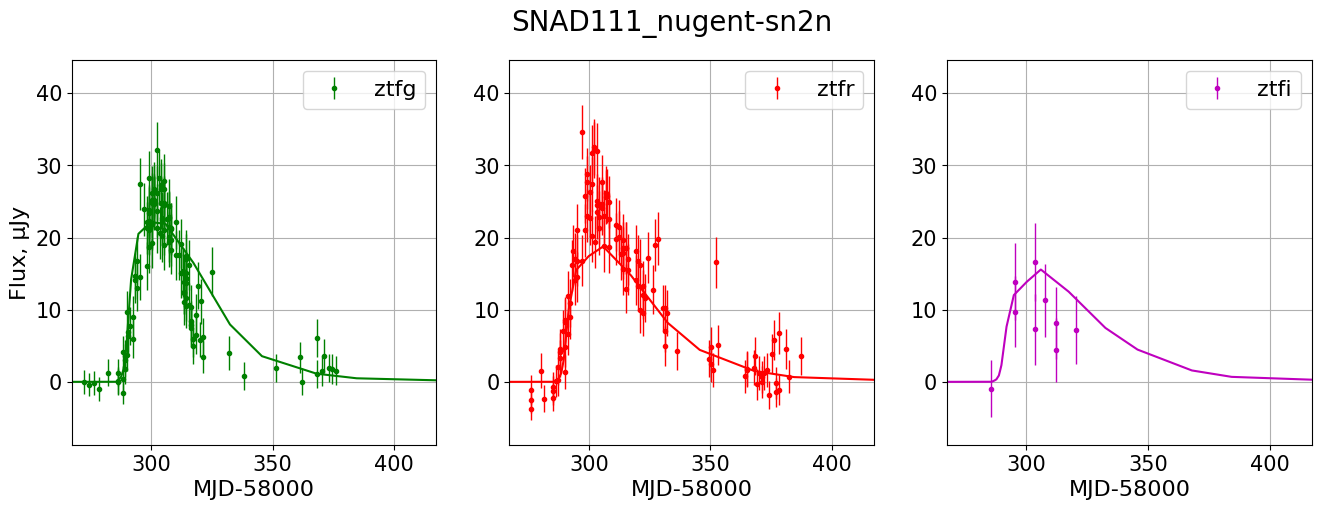

[5.82371853e-02 5.82861783e+04 9.53054011e-09 3.00000000e-02
 3.10000000e+00]
Uniq band ['ztfg' 'ztfr' 'ztfi']


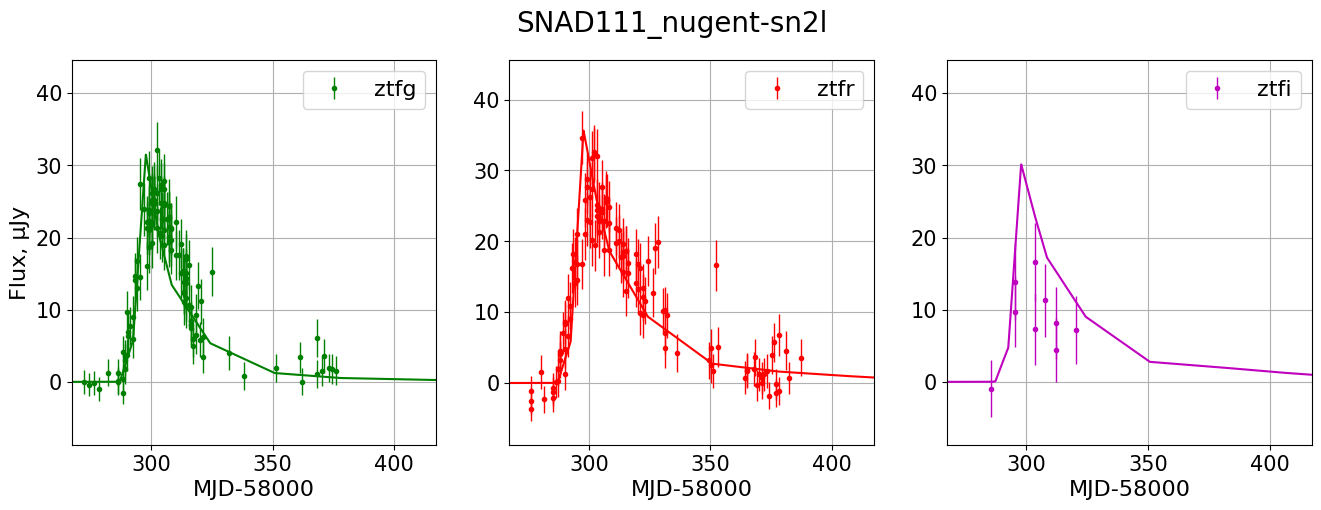

[1.16635964e-01 5.82865432e+04 6.98987802e-09 3.00000000e-02
 3.10000000e+00]
Uniq band ['ztfg' 'ztfr' 'ztfi']


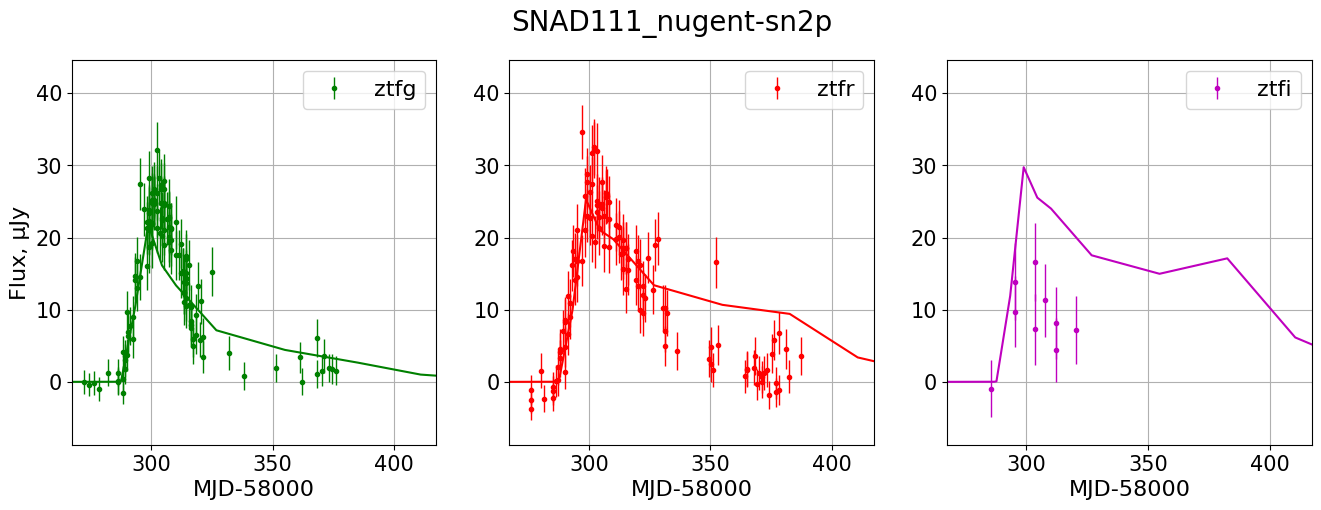

      name         model          M         chi2         z            t0  \
0  SNAD111   nugent-sn2l -17.372052   793.063485  0.058237  58286.178336   
1  SNAD111   nugent-sn2n -14.358322   846.265678  0.015000  58285.620034   
2  SNAD111  nugent-sn1bc -19.690651   878.546646  0.158620  58283.217691   
3  SNAD111   nugent-sn2p -18.965761  1131.546191  0.116636  58286.543172   
4  SNAD111   nugent-sn1a -19.524837  5799.311912  0.147927  58463.022812   

      amplitude  mwebv  mwr_v   max_mag  
0  9.530540e-09   0.03    3.1  19.77927  
1  6.154191e-09   0.03    3.1  19.77927  
2  7.480442e-09   0.03    3.1  19.77927  
3  6.989878e-09   0.03    3.1  19.77927  
4 -1.739723e-10   0.03    3.1  19.77927  
19.256176
[0.015, 0.3]


/home/user/Downloads/demo/notebookenv/lib/python3.11/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


[1.20943858e-01 5.82430302e+04 1.29588420e-08 3.00000000e-02
 3.10000000e+00]
Uniq band ['ztfg' 'ztfr' 'ztfi']


/tmp/ipykernel_15631/2336901342.py:160: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(data_band['mjd']-mjd_offset, data_band['flux'] * 10**6, yerr=data_band['fluxerr'] * 10**6, fmt="o", color=band_color[band], elinewidth=1, marker='.', label=band)


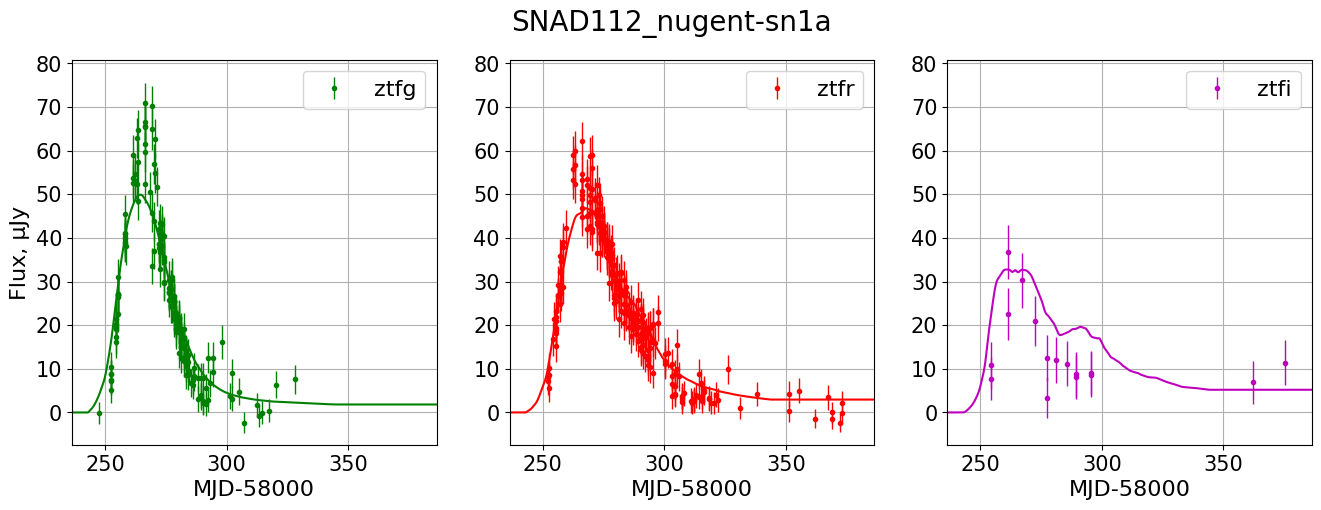

[1.50000019e-02 5.82469114e+04 1.56353888e-08 3.00000000e-02
 3.10000000e+00]
Uniq band ['ztfg' 'ztfr' 'ztfi']


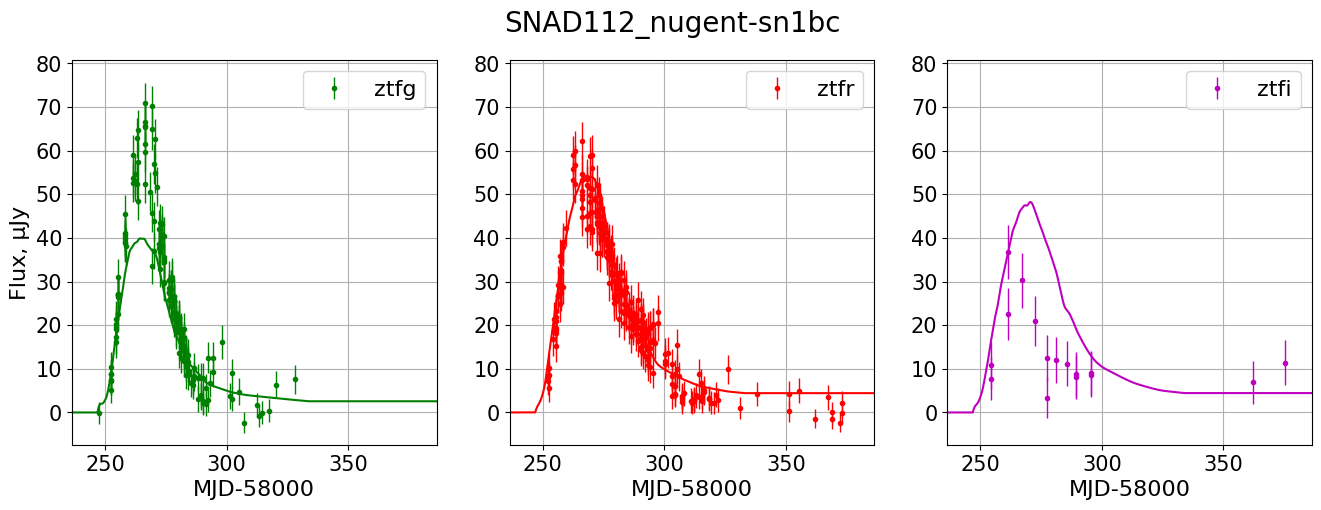

[1.50000000e-02 5.82478425e+04 1.17980969e-08 3.00000000e-02
 3.10000000e+00]
Uniq band ['ztfg' 'ztfr' 'ztfi']


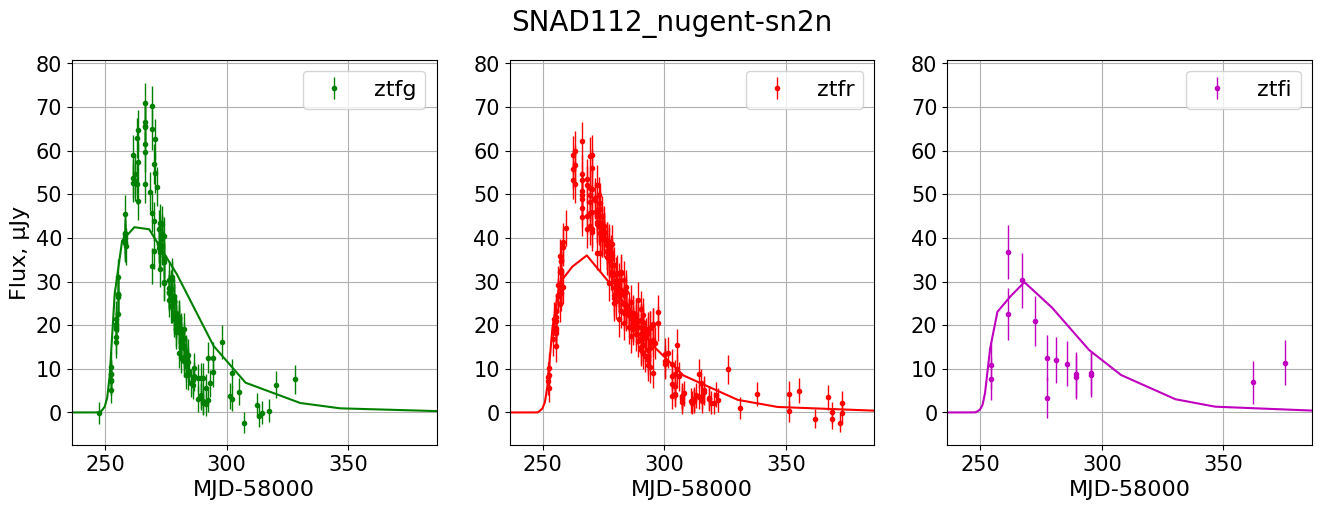

[2.61529388e-02 5.82496772e+04 2.17394643e-08 3.00000000e-02
 3.10000000e+00]
Uniq band ['ztfg' 'ztfr' 'ztfi']


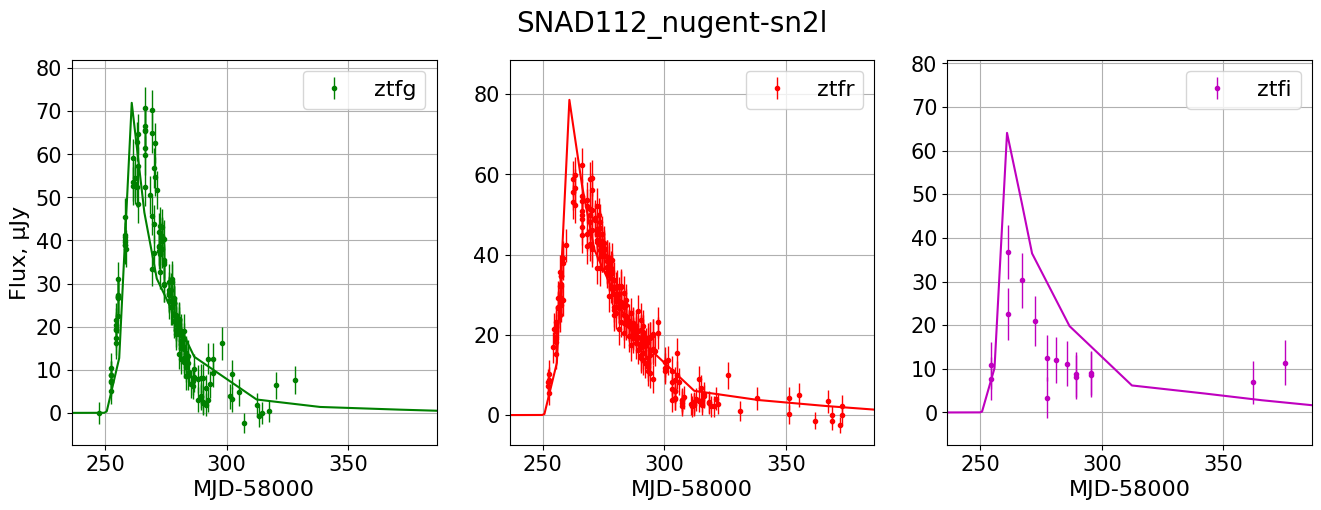

[1.12990370e-01 5.82484137e+04 1.26001217e-08 3.00000000e-02
 3.10000000e+00]
Uniq band ['ztfg' 'ztfr' 'ztfi']


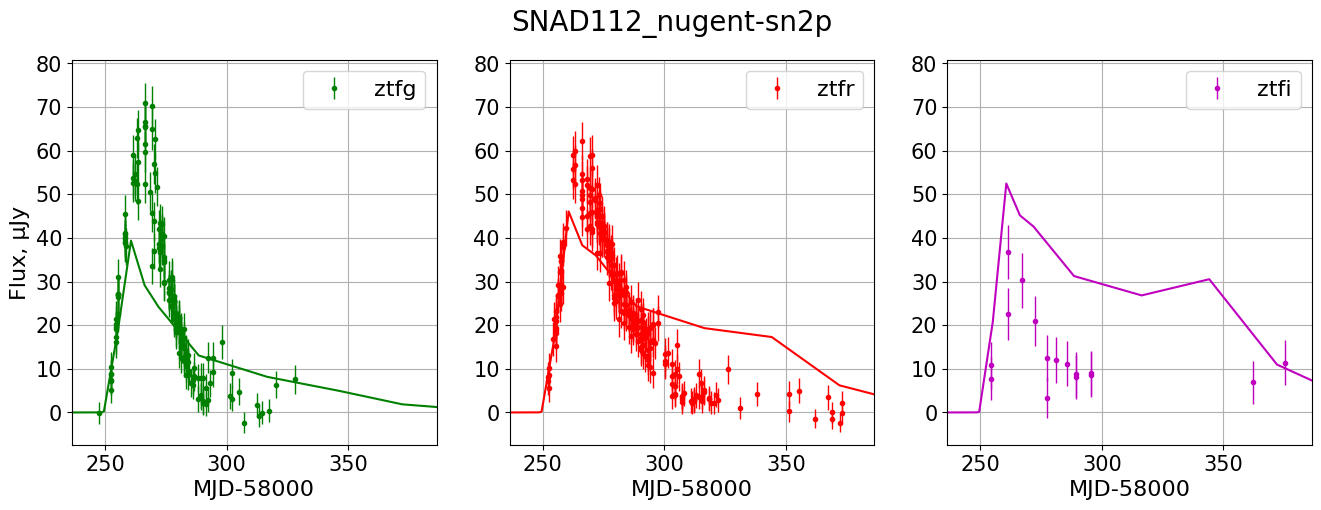

      name         model          M         chi2         z            t0  \
0  SNAD112   nugent-sn1a -19.573644   945.207703  0.120944  58243.030240   
1  SNAD112   nugent-sn2l -16.106568  1479.592379  0.026153  58249.677174   
2  SNAD112  nugent-sn1bc -14.881417  1488.724166  0.015000  58246.911390   
3  SNAD112   nugent-sn2n -14.881416  2587.678503  0.015000  58247.842549   
4  SNAD112   nugent-sn2p -19.414766  3942.774369  0.112990  58248.413701   

      amplitude  mwebv  mwr_v    max_mag  
0  1.295884e-08   0.03    3.1  19.256176  
1  2.173946e-08   0.03    3.1  19.256176  
2  1.563539e-08   0.03    3.1  19.256176  
3  1.179810e-08   0.03    3.1  19.256176  
4  1.260012e-08   0.03    3.1  19.256176  


In [10]:
objects = pd.read_csv('snad_catalog.csv')
objects = objects[objects['Type']=='PSN']
objects = pd.concat([objects[objects['Name'].apply(lambda x: int(x[4:]))==108], objects[objects['Name'].apply(lambda x: int(x[4:]))==111], 
    objects[objects['Name'].apply(lambda x: int(x[4:]))==112]])
print(objects)
for oid in objects['OID']:
    task(oid, list_nugent, 3000, [0.01, 0.65])

(1, 13)
(687, 9)
ztfr
58591.41749
0           none
1           none
2           none
3           none
4           none
         ...    
682    explosion
683    explosion
684         none
685         none
686         none
Name: flag, Length: 687, dtype: object


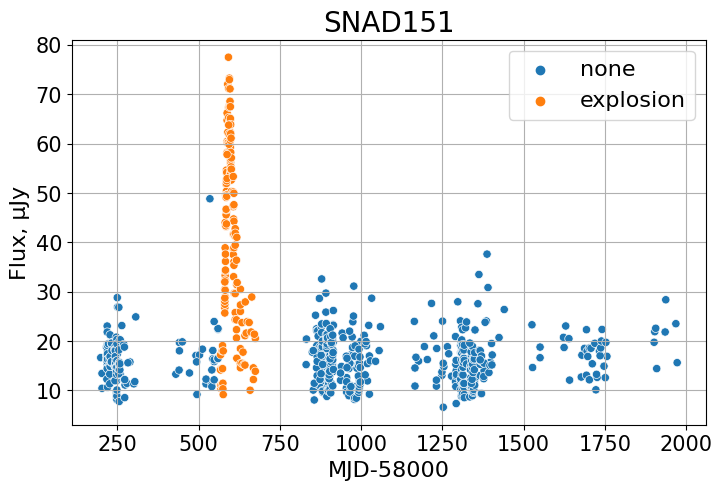

159
288
70
{'ztfg': (1.1309196382774906e-05, 2.3297585257354168e-07), 'ztfr': (1.6619570856979578e-05, 2.1858922305074128e-07), 'ztfi': (1.999063864024673e-05, 4.4151551332276437e-07)}


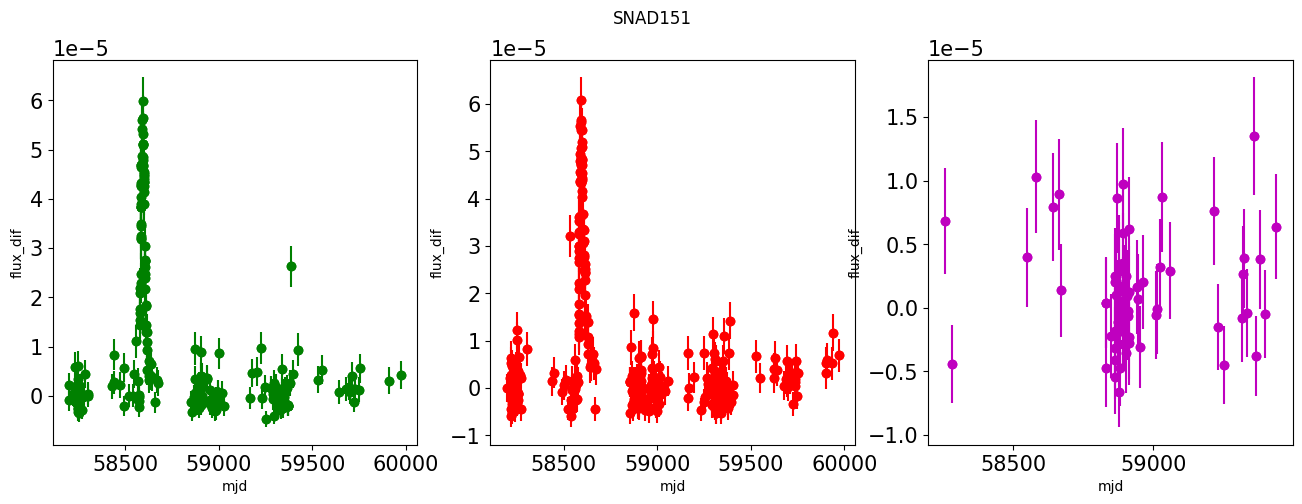

[None]

In [14]:
#Расчет референсного значения, скорректированного потока и удаление выбросов
import math
import sklearn
from sklearn.ensemble import IsolationForest
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


snadoid_to_del = { #удалить выбросы
    208 : {'ztfr' : [59531.11098]}, 
    214 : {'ztfr' : [58879.55179], 'ztfg' : [59685.38839]},
    215 : {'ztfr' : [59304.47646, 58781.09242], 'ztfg' : [58480.53035]}, 
    220 : {'ztfr' : [58589.28968]},
    221 : {'ztfr' : [59707.47782]}, 
    222 : {'ztfr' : [58879.53719]},
    223 : {'ztfr' : [58883.51970, 58506.43773]}, 
    225 : {'ztfr' : [59503.09914]},
    226 : {'ztfr' : [58431.13555]}, 
    228 : {'ztfr' : [59301.42777]},
    229 : {'ztfr' : [58879.55417]},
    230 : {'ztfg' : [58732.14002]},
    234 : {'ztfr' : [59497.18369]},
    239 : {'ztfr' : [59478.17366]},
    #241 : {'ztfr' : [58890.48614, 58854.57833]},
    106 : {'ztfr' : [58538.47387]},
    107 : {'ztfr' : [58385.21125]},
    116 : {'ztfr' : [59301.39527]},
    125 : {'ztfi' : [59005.34248]},
    144 : {'ztfr' : [59600.50723]},
    188 : {'ztfr' : [58538.47419]},
    152 : {'ztfr' : [58884.57480, 58879.53630]},
    #238 : {'ztfr' : [58257.40591, 58247.40751]},
    202 : {'ztfi' : [58747.11199]},
    169 : {'ztfi' : [58893.40709]},
    163 : {'ztfg' : [59149.17860]},
}


snadoid_to_ref = { # нет точек чтобы вычислить референс, значения из вьюера
    122 : {'ztfr' : [21.939, 0.19], 'ztfi' : [20.085, 0.039]},
    165 : {'ztfr' : [21.652, 0.14], 'ztfg' : [21.577, 0.11], 'ztfi' : [21.173, 0.153]}
}


#snadoid_to_tmax_ref = { # время максимума ставим вручную для расчета референса, иначе не строится фит
    
#}


def calc_ref(oid, snadoid):
    band_ref = dict()
    data = pd.read_csv('curves/' + str(oid) + '.csv')
    data.drop(columns = ['Unnamed: 0'],axis = 1, inplace=True)
    data['Name'] = snadoid
    try: data['band'] = data['filter'].str.replace('z', 'ztf')
    except: data['band'] = data['band'].str.replace('z', 'ztf')
    data['flux'] = 10**(-0.4 * (data['mag']-8.9)) #* 10**6
    data['fluxerr'] = abs(-0.4 * math.log(10.0) * 10**(-0.4 * (data['mag']-8.9)) * data['magerr']) #* 10**6
    list_df = []
    snadoid_cut = int(snadoid[4:])
    if snadoid_cut in snadoid_to_del.keys():
        for band in data['band'].unique():
            if band in snadoid_to_del[snadoid_cut].keys():
                data_key = data[data['band']==band]
                data_key['mjd_str'] = data_key['mjd'].astype(str)
                deleted = snadoid_to_del[snadoid_cut][band]
                #for time in deleted:
                print(data_key.shape)
                    #data_key = data_key.loc[str(data_key['mjd'])!=str(time)]
                print('Deleted: ', deleted)
                data_key = data_key.loc[~data_key['mjd_str'].isin([str(i) for i in deleted])]
                print(data_key.shape)
                list_df.append(data_key)
            else: list_df.append(data[data['band']==band])
        data = pd.concat(list_df, axis=0)
    print(data.shape)
    data_r = data[data['band']=='ztfr']
    data_g = data[data['band']=='ztfg']
    #plt.scatter(data['mjd'], data['flux'])
    #plt.errorbar(data['mjd'], data['flux'], yerr=data['fluxerr'], fmt="o")
    #plt.show()
    if data_r.shape[0]>data_g.shape[0]:
        print('ztfr')
        data_max = data_r
    else: 
        print('ztfg')
        data_max = data_g
    #t_max_mag = data_max[data_max['mag']==data_max['mag'].min()]['mjd'].values[0]
    if snadoid_cut in oid_to_tmax.keys(): t_max_mag = oid_to_tmax[snadoid_cut] 
    else: t_max_mag = data_max[data_max['mag']==data_max['mag'].min()]['mjd'].values[0] 
    print(t_max_mag)
    
    #
    data_cut = data[((data['mjd'] <= t_max_mag-30) | (data['mjd'] >= t_max_mag+120))] 
    data['flag'] = [ 'explosion' if (m>= t_max_mag-30) & (m<= t_max_mag+120) else 'none' for m in data['mjd']]
    print(data['flag'])
    #ax = plt.subplot()
    f = plt.figure(figsize=(18,5))
    ax = f.add_subplot(121)
    plt.title(snadoid, fontsize=20)
    sns.scatterplot(x=data['mjd']-58000, y=data['flux']*10**6, hue = data['flag'])
    #plt.errorbar(data['mjd'], data['flux'], yerr=data['fluxerr'], fmt="o")
    ax.set_xlabel("MJD-58000", fontsize=16)  
    matplotlib.rc('xtick', labelsize=15) 
    ax.set_ylabel("Flux, " + "μ" + "Jy", fontsize=16)
    matplotlib.rc('ytick', labelsize=15)
    ax.grid(which='major')
    ax.legend(prop={"size":16})
    plt.savefig('snad151_flux_dif')
    plt.show()
    #
    
    for band in data['band'].unique():
        data_band = data_cut[data_cut['band']==band]
        print(data_band.shape[0])
        if data_band.shape[0]==1:
            band_ref[band] = (list(data_band['flux'])[0],list(data_band['fluxerr'])[0])
        elif snadoid_cut in snadoid_to_ref.keys():
            ref = snadoid_to_ref[snadoid_cut][band][0]
            referr = snadoid_to_ref[snadoid_cut][band][1]
            band_ref[band] = 10**(-0.4 * (ref-8.9)), abs(-0.4 * math.log(10.0) * 10**(-0.4 * (ref-8.9)) * referr)
        else:
            #p = (data_band['fluxerr']**(-2)).sum()
            #ref = ((data_band['flux'] * data_band['fluxerr']**(-2)).sum()) / p
            #print(ref)
            #band_ref[band] = (ref, (((data_band['fluxerr'] ** (-1) / p)**2).sum())**0.5)
            n = data_band.shape[0]
            #print(data_band.shape)
            p = 1 / (data_band['fluxerr'])**2
            ref = (p * (data_band['flux']-data_band['flux'].mean())).sum() / p.sum() + data_band['flux'].mean()
            err_eps = 1 / ((p.sum())**0.5)
            #print(data_band['flux'],'\n mean is ', data_band['flux'].mean())
            err_corr = (( (p*(data_band['flux']-data_band['flux'].mean())**2).sum())/(n-1))**0.5
            err_eps_corr = err_corr / ((p.sum())**0.5)
            dict_error = {}
            dict_error['name'] = snadoid
            dict_error['band'] = band
            if err_eps > err_eps_corr: 
                err = (err_eps + err_eps_corr) / 2
                dict_error['error'] = 'instrumental'#'mean(4,133)'
                dict_error['value'] = err
            else: 
                err = err_eps_corr
                #print('err_eps_corr is', err)
                dict_error['error'] = 'intrinsic'#'(4,131)'
                dict_error['value'] = err
            #err = ((data_band['fluxerr'].mean())**2 / p.sum())**0.5
            list_error= []
            list_error.append(dict_error)
            df = pd.DataFrame(list_error)
            df.to_csv('id_error.csv', mode='a', index= False, header=False)
            band_ref[band] = (ref,err)
            #data[data['band']==band]['referr_calc'] = data[data['band']==band]['referr'].mean()
    print(band_ref)
    data['ref'] = data['band'].apply(lambda x: band_ref[x][0])
    data['referr'] = data['band'].apply(lambda x: band_ref[x][1])
    data['flux_dif'] = data['flux'] - data['ref']
    data['flux_dif_err'] = ((data['fluxerr'])**2 + (data['referr'])**2)**0.5
    
    band_color = {'ztfr' : 'r', 'ztfg' : 'g', 'ztfi' : 'm'}
    fig, axes = plt.subplots(1, 3, figsize=(16,5))
    plt.suptitle(str(snadoid))
    for band, ax in zip(data['band'].unique(), axes):
        #ax.set_xlim([t_max_mag-30, t_max_mag+120])
        data_band = data[data['band']==band]
        ax.scatter(x=data_band['mjd'], y=data_band['flux_dif'], color=band_color[band])
        #sns.scatterplot(data=data, x='mjd', y='flux_dif', hue='band')
        ax.errorbar(data_band['mjd'], data_band['flux_dif'], yerr=data_band['flux_dif_err'], fmt="o", color=band_color[band])
        ax.set_xlabel("mjd")
        ax.set_ylabel("flux_dif")
    plt.show()
    
    data.to_csv('data_calc_ref/'+str(oid)+ '.csv')

    
df = pd.DataFrame(columns=['name', 'band', 'error', 'value'])
df.to_csv('id_error.csv', mode='a', index= False)    
objects = pd.read_csv('snad_catalog.csv')
objects = objects[objects['Type']=='PSN']
objects1 = objects[(objects['Name'].apply(lambda x: int(x[4:]))>=151) & (objects['Name'].apply(lambda x: int(x[4:]))<=151)]
print(objects1.shape)
[calc_ref(oid, snadoid) for oid, snadoid in zip(objects1['OID'], objects1['Name'])] 

#objects2 = objects[(objects['Name'].apply(lambda x: int(x[4:]))>=115) & (objects['Name'].apply(lambda x: int(x[4:]))<=122)]
#print(objects2.shape)
#[calc_ref(oid, snadoid) for oid, snadoid in zip(objects2['OID'], objects2['Name'])]

#objects3 = objects[(objects['Name'].apply(lambda x: int(x[4:]))>=123) & (objects['Name'].apply(lambda x: int(x[4:]))<=140)]
#print(objects3.shape)
#[calc_ref(oid, snadoid) for oid, snadoid in zip(objects3['OID'], objects3['Name'])]

#objects4 = objects[(objects['Name'].apply(lambda x: int(x[4:]))>=141) & (objects['Name'].apply(lambda x: int(x[4:]))<=165)]
#print(objects4.shape)
#[calc_ref(oid, snadoid) for oid, snadoid in zip(objects4['OID'], objects4['Name'])]

#objects5 = objects[(objects['Name'].apply(lambda x: int(x[4:]))>=166) & (objects['Name'].apply(lambda x: int(x[4:]))<=244)]
#print(objects5.shape)
#[calc_ref(oid, snadoid) for oid, snadoid in zip(objects5['OID'], objects5['Name'])]

In [5]:
df = pd.DataFrame(columns=['name', 'model', 'error', 'text'])
df.to_csv('id_exception_v23.csv', mode='a', index= False)
df = pd.DataFrame(columns=['name', 'model', 'M', 'chi2', 'z',
                    't0', 'amplitude', 'mwebv','mwr_v', 'max_mag'])
df.to_csv('id_result_z_v14.csv', mode='a', index= False)

In [24]:
import pandas as pd
df = pd.DataFrame(columns=['name', 'model', 'M', 'chi2', 'z', 't0', 'amplitude', 'mwebv', 'mwr_v', 'max_mag'])
df.to_csv('result_z_v8.csv', mode='a', index= False)
results = pd.read_csv('id_result_z_v8.csv')
for obj in results['name'].unique():
    df_obj = results[results['name']==obj].sort_values(by='chi2')
    #df_obj.drop(['z', 't0', 'amplitude', 'mwebv', 'mwr_v'], axis= 1 , inplace= True)
    df_obj = df_obj.head(1)
    df_obj.to_csv('result_z_v8.csv', mode='a', index= False, header=False)

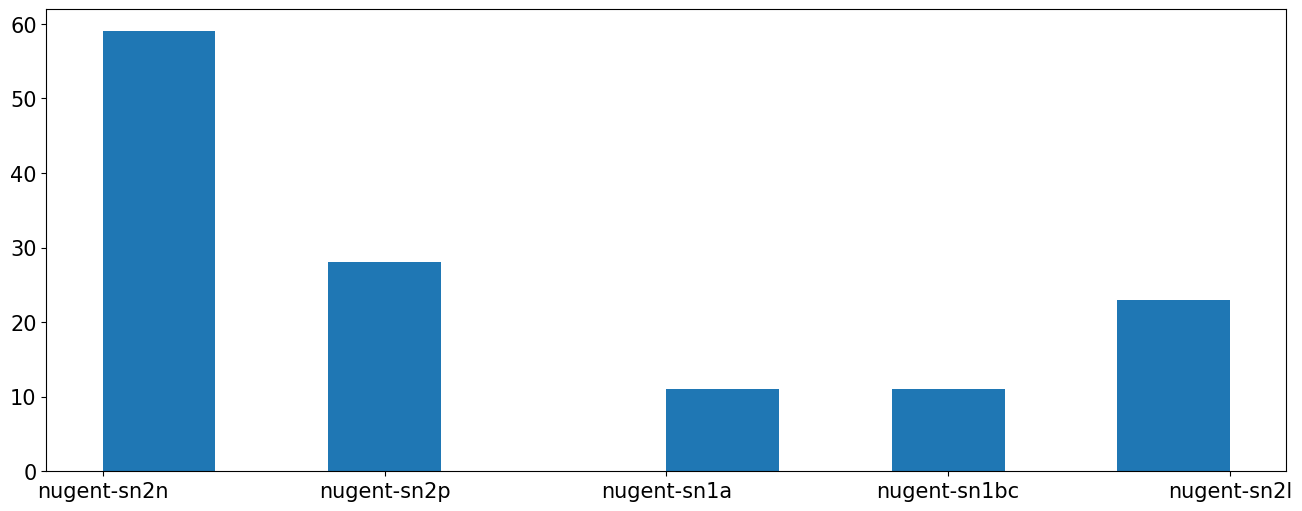

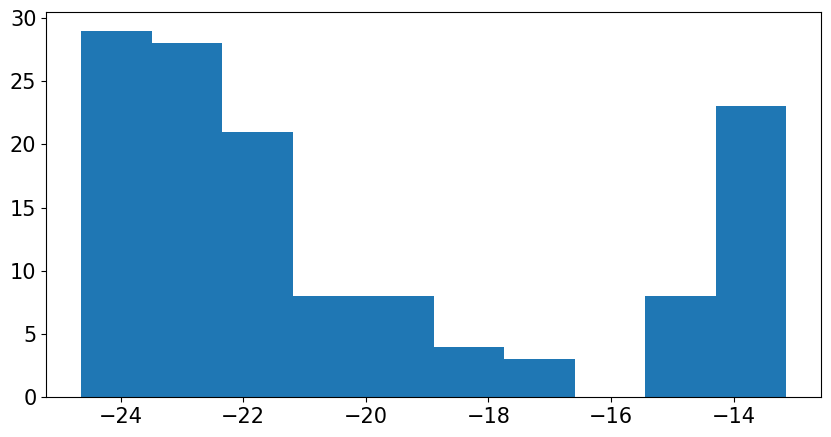

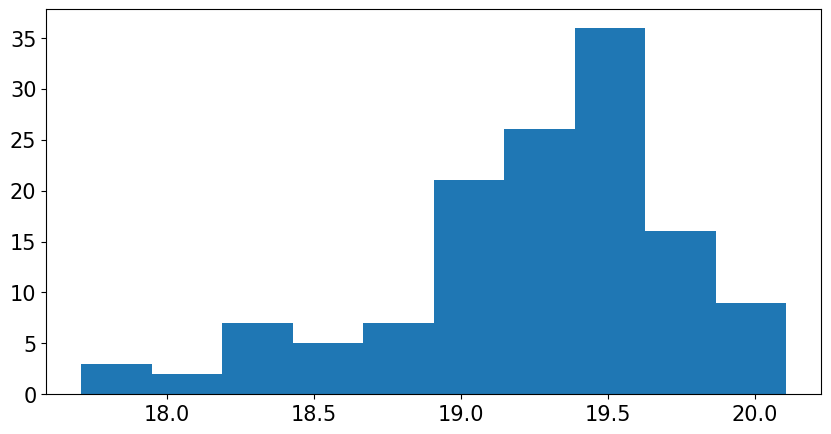

In [25]:
results_cut = pd.read_csv('result_z_v9.csv')
fig, ax = plt.subplots(1, 1, figsize=(16,6))
ax.hist(results_cut['model'])
plt.show()
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.hist(results_cut['M'])
plt.show()
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.hist(results_cut['max_mag'])
plt.show()

In [7]:
#!pip install shutil
import shutil
import pandas as pd


results_cut = pd.read_csv('result_z_v2.csv')
for n, m in zip(results_cut['name'], results_cut['model']):
    nm = n + '_' + m + '.png'
    shutil.copy('Lom/' + nm, 'Lom/Best_v2/' + nm)

In [24]:
#Сравнение с Pruzhinskaya_2023
import pandas as pd
import numpy as np

df1 = pd.read_csv('snad_objects_Pruzhinskaya_2023.txt', sep=' ')
df1 = df1[['Name', 'Type']]
df1['Type'] = df1['Type'].apply(lambda x: str(x))#.lower())
df2 = pd.read_csv('result_v9.csv')
df2 = df2[['name', 'model']]
df2['model'] = df2['model'].apply(lambda x: 
                                  str(x[9:]).replace('2', 'II').replace('1', 'I').replace('p', 'P').replace('l', 'L'))
res = df1.set_index('Name').join(df2.set_index('name'))
res['check'] = [i==j if str(j)!='nan' else j for i, j in  zip(res['Type'], res['model'])]
#res.drop_duplicates(subset=[])
res = res[~res.index.duplicated()].copy()
print(res)
print('% correct', float(res[res['check']==True].shape[0])/
      (res[res['check']==True].shape[0] + res[res['check']==False].shape[0])*100)

        Type model  check
SNAD101  IIn   IIP  False
SNAD102  IIn   IIn   True
SNAD103  IIP   NaN    NaN
SNAD104  IIP   IIP   True
SNAD105  Ibc   NaN    NaN
SNAD106   Ia   IIL  False
SNAD107  Ibc   IIL  False
SNAD108   Ia  9Ibg  False
SNAD109  IIn   IIP  False
SNAD111  Ibc    Ia  False
SNAD112   Ia    Ia   True
SNAD113   Ia    Ia   True
SNAD114  IIn   IIn   True
SNAD115  IIn   IIP  False
SNAD116   Ia   IIn  False
SNAD117  IIP   NaN    NaN
SNAD119  IIn   IIn   True
SNAD120  IIP   IIP   True
SNAD121  IIP   IIn  False
SNAD122  IIP   IIn  False
SNAD123  IIn    Ia  False
SNAD124  IIL   IIL   True
SNAD125   Ia   IIn  False
SNAD126  IIn   NaN    NaN
SNAD127  IIn   IIP  False
SNAD128  IIn   IIn   True
SNAD129  IIL   IIL   True
SNAD130   Ia   IIn  False
SNAD131  Ibc   IIn  False
SNAD132  Ibc  9Ibg  False
SNAD133   Ia   IIL  False
SNAD134   Ia    Ia   True
SNAD135  IIn   Per  False
SNAD136   Ia   IIn  False
SNAD137  IIn   IIn   True
SNAD138   Ia   IIn  False
SNAD139  IIn   9It  False
SNAD141   Ia

        name         model          M           mse         z            t0  \
0    SNAD101   nugent-sn2n -21.706358  7.983519e-10  0.296034  58342.692197   
1    SNAD101   nugent-sn1a -21.732170  8.148849e-10  0.299109  58337.683079   
5    SNAD102   nugent-sn2n -16.180999  7.394753e-10  0.025001  58284.495719   
16   SNAD106   nugent-sn2n -15.337438  1.496190e-10  0.024577  58225.632112   
23   SNAD107  nugent-sn1bc -22.016166  3.292971e-11  0.443686  58231.891981   
..       ...           ...        ...           ...       ...           ...   
610  SNAD235   nugent-sn2n -21.204600  5.109035e-11  0.292503  58192.408807   
612  SNAD235  nugent-sn1bc -15.447353  5.630474e-11  0.024337  58191.651792   
636  SNAD240   nugent-sn1a -21.648699  7.443102e-11  0.292207  58234.428664   
640  SNAD241   nugent-sn1a -21.641868  5.237976e-11  0.290771  58208.714460   
651  SNAD243   nugent-sn2n -24.900114  3.045611e-10  0.642959  58200.821773   

        amplitude  mwebv  mwr_v    max_mag  
0    7

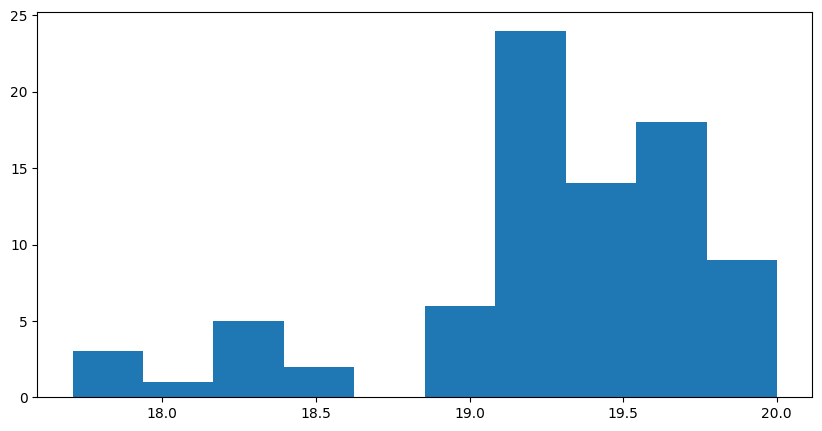

['SNAD101' 'SNAD102' 'SNAD106' 'SNAD107' 'SNAD108' 'SNAD109' 'SNAD111'
 'SNAD112' 'SNAD114' 'SNAD115' 'SNAD120' 'SNAD121' 'SNAD124' 'SNAD125'
 'SNAD127' 'SNAD128' 'SNAD131' 'SNAD132' 'SNAD136' 'SNAD140' 'SNAD142'
 'SNAD143' 'SNAD145' 'SNAD146' 'SNAD150' 'SNAD159' 'SNAD160' 'SNAD163'
 'SNAD165' 'SNAD166' 'SNAD167' 'SNAD168' 'SNAD169' 'SNAD172' 'SNAD178'
 'SNAD180' 'SNAD183' 'SNAD185' 'SNAD187' 'SNAD190' 'SNAD191' 'SNAD196'
 'SNAD198' 'SNAD201' 'SNAD202' 'SNAD204' 'SNAD205' 'SNAD206' 'SNAD217'
 'SNAD218' 'SNAD219' 'SNAD220' 'SNAD221' 'SNAD222' 'SNAD226' 'SNAD232'
 'SNAD235' 'SNAD240' 'SNAD241' 'SNAD243']


In [3]:
df = pd.read_csv('id_result_z_v12.csv')
df = df[(abs(df['z']-0.3)<0.01) | (abs(df['z']-0.015)<0.001) | (abs(df['z']-0.45)<0.01) | 
    (abs(df['z']-0.025)<0.001) | (abs(df['z']-0.65)<0.01) | (abs(df['z']-0.035)<0.001)]
# [0.035,0.65] # [-15,-22] for 21 mag
#     elif max_mag>=20:
#         redshift = [0.025,0.45] # [-15,-22] for 20 mag
#     elif max_mag>=19:
#         redshift = [0.015,0.30] # [-15,-22] for 19 mag
print(df)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.hist(df['max_mag'])
plt.show()
print(df['name'].unique())

In [22]:
# df = pd.DataFrame(columns=['name', 'model', 'M', 'chi2', 'z',
#                     't0', 'amplitude', 'mwebv','mwr_v'])
# df.to_csv('id_result_z_v4.csv', mode='a', index= False)
objects = pd.read_csv('snad_catalog.csv')
objects = objects[objects['Type']=='PSN']
objects = objects[objects['Name'].apply(lambda x: int(x[4:]))>=101]
print(objects)
for oid in objects['OID']:
    task(oid, list_nugent, 3000, [0.01, 0.3])

        Name       R.A.      Dec.              OID  Discovery date (UT)   
0    SNAD101  247.45543  24.77282  633207400004730  2018-04-08 09:45:49  \
1    SNAD102  245.05375  28.38220  633216300024691  2018-03-21 11:08:19   
3    SNAD104  218.91620  46.38441  758205400019523  2018-06-24 07:23:27   
5    SNAD106  219.41935  50.16706  758213400002862  2018-05-04 07:48:50   
6    SNAD107  254.41703  44.29804  762202300014913  2018-05-04 07:39:44   
..       ...        ...       ...              ...                  ...   
139  SNAD240  250.78941  66.39883  847102300000383  2018-05-10 08:48:46   
140  SNAD241  240.77847  47.31124  761108100005391  2018-04-22 08:42:04   
141  SNAD242  171.50084  44.96460  753101100007466  2018-06-03 04:41:06   
142  SNAD243  113.91920  31.77959  662105400007673  2018-03-30 05:34:18   
143  SNAD244  250.59311  24.97684  633105300018089  2018-03-30 10:48:56   

       mag  er_down  er_up    ref  er_ref         TNS Type      Comments  
0    21.11     0.27   0.

ValueError: z must be bounded if fit.

In [38]:
df = pd.DataFrame(columns=['name', 'model', 'M', 'chi2', 'z', 't0', 'amplitude', 'mwebv', 'mwr_v'])
df.to_csv('result_z_v2_&.csv', mode='a', index= False)
results = pd.read_csv('id_result_z_v2.csv')
for obj in results['name'].unique():
    df_obj = results[results['name']==obj].sort_values(by='chi2')
    #df_obj.drop(['z', 't0', 'amplitude', 'mwebv', 'mwr_v'], axis= 1 , inplace= True)
    df_obj = df_obj.head(1)
    #print(df_obj)
    df_obj_cut = pd.DataFrame()
    for key in df_obj.keys():
        if key not in ['model', 'name', 'amplitude']:
            df_obj_cut[key] = round(df_obj[key], 3)
        elif key == 'amplitude':
            df_obj_cut[key] = round(df_obj[key], 11)
        else: df_obj_cut[key] = df_obj[key]
    #print(df_obj_cut)
    df_obj_cut.to_csv('result_z_v2_&.csv', mode='a', index= False, header=False, sep='&')

In [37]:
import pandas as pd
df = pd.read_csv('id_result_z_v9.csv')
df = df[(abs(df['z']-0.3)<0.01)| (abs(df['z']-0.01)<0.001)]
print(df)

        name        model          M         chi2         z            t0   
5    SNAD102  nugent-sn2n -14.166905  1014.921558  0.010000  58284.877143  \
17   SNAD106  nugent-sn2n -13.361180   725.604522  0.010000  58226.127746   
22   SNAD107  nugent-sn2n -13.247668   351.785229  0.010000  58234.886846   
28   SNAD108  nugent-sn2n -14.157594  1332.536194  0.010000  58278.971807   
40   SNAD111  nugent-sn2n -13.469697   255.264658  0.010000  58285.677585   
..       ...          ...        ...          ...       ...           ...   
625  SNAD238  nugent-sn2n -14.399828  2435.412699  0.010000  58305.550840   
632  SNAD239  nugent-sn2n -13.626018   772.219221  0.010000  58294.866096   
635  SNAD240  nugent-sn2n -13.939502   885.970249  0.010001  58240.712531   
641  SNAD241  nugent-sn2n -13.944839  2461.784888  0.010000  58870.285947   
646  SNAD242  nugent-sn2n -14.353595  1646.541493  0.010000  58268.779795   

        amplitude  mwebv  mwr_v    max_mag  
5    1.642350e-08   0.06    3.

In [34]:
#Сравнение с Pruzhinskaya_2023 (z)
import pandas as pd
import numpy as np

df1 = pd.read_csv('snad_objects_Pruzhinskaya_2023.txt', sep=' ')
df1 = df1[['Name', 'Type']]
df1['Type'] = df1['Type'].apply(lambda x: str(x))#.lower())
df2 = pd.read_csv('result_z_v7.csv')
df2 = df2[['name', 'model']]
df2['model'] = df2['model'].apply(lambda x: 
                                  str(x[9:]).replace('2', 'II').replace('1', 'I').replace('p', 'P').replace('l', 'L'))
res = df1.set_index('Name').join(df2.set_index('name'))
res['check'] = [i==j if str(j)!='nan' else j for i, j in  zip(res['Type'], res['model'])]
#res.drop_duplicates(subset=[])
res = res[~res.index.duplicated()].copy()
print(res)
print('% correct', float(res[res['check']==True].shape[0])/
      (res[res['check']==True].shape[0] + res[res['check']==False].shape[0])*100)

        Type model  check
SNAD101  IIn   IIP  False
SNAD102  IIn   IIn   True
SNAD103  IIP   NaN    NaN
SNAD104  IIP   IIP   True
SNAD105  Ibc   NaN    NaN
SNAD106   Ia    Ia   True
SNAD107  Ibc   IIL  False
SNAD108   Ia   IIn  False
SNAD109  IIn   IIP  False
SNAD111  Ibc   IIL  False
SNAD112   Ia    Ia   True
SNAD113   Ia    Ia   True
SNAD114  IIn   IIn   True
SNAD115  IIn   IIP  False
SNAD116   Ia   IIn  False
SNAD117  IIP   NaN    NaN
SNAD119  IIn   IIn   True
SNAD120  IIP   IIP   True
SNAD121  IIP   IIn  False
SNAD122  IIP   IIP   True
SNAD123  IIn    Ia  False
SNAD124  IIL   IIL   True
SNAD125   Ia   IIn  False
SNAD126  IIn   NaN    NaN
SNAD127  IIn   IIP  False
SNAD128  IIn    Ia  False
SNAD129  IIL   IIL   True
SNAD130   Ia   IIn  False
SNAD131  Ibc    Ia  False
SNAD132  Ibc   IIL  False
SNAD133   Ia   IIL  False
SNAD134   Ia    Ia   True
SNAD135  IIn   IIn   True
SNAD136   Ia   IIn  False
SNAD137  IIn   IIn   True
SNAD138   Ia   IIn  False
SNAD139  IIn   IIn   True
SNAD141   Ia